# SOTA Approach for Solving Lyapunov Function

## Setup 

In [27]:
import torch
import numpy as np
import timeit
import matplotlib.pyplot as plt
import math
import sympy as sym
from numpy import random
import torch.nn.functional as F
import sympy as sym
from sympy import lambdify
from dreal import *
from mpl_toolkits import mplot3d
%matplotlib inline

## Helper function used for training

In [28]:
# Helper Function

from dreal import *
import torch 
import numpy as np
import random


def CheckLyapunov(x, f, V, ball_lb, ball_ub, config, epsilon):    
    # Given a dynamical system dx/dt = f(x,u) and candidate Lyapunov function V
    # Check the Lyapunov conditions within a domain around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub). 
    # If it return unsat, then there is no state violating the conditions. 
    
    ball= Expression(0)
    lie_derivative_of_V = Expression(0)
    
    for i in range(len(x)):
        ball += x[i]*x[i]
        lie_derivative_of_V += f[i]*V.Differentiate(x[i])  
    ball_in_bound = logical_and(ball_lb*ball_lb <= ball, ball <= ball_ub*ball_ub)
    
    # Constraint: x ∈ Ball → (V(c, x) > 0 ∧ Lie derivative of V <= 0)     
    condition = logical_and(logical_imply(ball_in_bound, V >= 0),
                           logical_imply(ball_in_bound, lie_derivative_of_V <= epsilon))
    return CheckSatisfiability(logical_not(condition),config)

def AddCounterexamples(x,CE,N): 
    # Adding CE back to sample set
    c = []
    nearby= []
    for i in range(CE.size()):
        c.append(CE[i].mid())
        lb = CE[i].lb()
        ub = CE[i].ub()
        nearby_ = np.random.uniform(lb,ub,N)
        nearby.append(nearby_)
    for i in range(N):
        n_pt = []
        for j in range(x.shape[1]):
            n_pt.append(nearby[j][i])             
        x = torch.cat((x, torch.tensor([n_pt])), 0)
    return x
  
def dtanh(s):
    # Derivative of activation
    return 1.0 - s**2

def Tune(x):
    # Circle function values
    y = []
    for r in range(0,len(x)):
        v = 0 
        for j in range(x.shape[1]):
            v += x[r][j]**2
        f = [torch.sqrt(v)]
        y.append(f)
    y = torch.tensor(y)
    return y

## Neural Network

In [29]:
class Net(torch.nn.Module):

    def __init__(self,n_input,n_hidden,n_output,lqr):
        super(Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = torch.nn.Linear(n_input, n_hidden)
        self.layer2 = torch.nn.Linear(n_hidden,n_output)
        self.control = torch.nn.Linear(n_input,1,bias=False)
        self.control.weight = torch.nn.Parameter(lqr)

    def forward(self,x):
        sigmoid = torch.nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        u = self.control(x)
        return out,u


## Dynamics Setup

In [36]:
def f_value(x,u):
    v = 6
    l = 1
    y = [] 
    
    for r in range(0,len(x)): 
        f = [v*torch.sin(x[r][1]),
             -x[r][1] - v * torch.sin(x[r][1]) * x[r][0] / (x[r][1] if x[r][1] != 0 else 0.0001)]
        y.append(f) 
    y = torch.tensor(y)    
    return y

## Data Preparation for Training

In [37]:
'''
For learning 
'''
N = 500            # sample size
D_in = 2            # input dimension
H1 = 6              # hidden dimension
D_out = 1           # output dimension
torch.manual_seed(10)  

lqr = torch.tensor([[-0.8471 , -1.6414]])  # lqr solution
x = torch.Tensor(N, D_in).uniform_(-1, 1).to(torch.double)           
x_0 = torch.zeros([1, 2]).to(torch.double)
x = torch.cat((x, x_0), 0)

'''
For verifying 
'''
x1 = Variable("x1")
x2 = Variable("x2")
vars_ = [x1,x2]
v = 6
l = 1
config = Config()
config.use_polytope_in_forall = True
config.use_local_optimization = True
config.precision = 1e-2
epsilon = 0
# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 0.2
ball_ub = 0.8

## Training

In [38]:
out_iters = 0
valid = False
while out_iters < 2 and not valid:
    start = timeit.default_timer()
    lqr = torch.tensor([[-0.8471 , -1.6414]]).to(torch.double) # lqr solution
    model = Net(D_in,H1, D_out,lqr).double()
    L = []
    i = 0
    t = 0
    max_iters = 2000
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    while i < max_iters and not valid:
        V_candidate, u = model(x)
        X0,u0 = model(x_0)
        f = f_value(x,u)
        Circle_Tuning = Tune(x)
        # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model.layer1.weight.t().to(torch.double))+model.layer1.bias.to(torch.double))),model.layer1.weight.to(torch.double)),f.t().to(torch.double)),0)

        # With tuning term
        Lyapunov_risk = (F.relu(-V_candidate)+ 2*F.relu(L_V+0.8)).mean()\
                    +1.5*((Circle_Tuning-V_candidate).pow(2)).mean()+ 1.2*(X0).pow(2)       
        

        print(i, "Lyapunov Risk=",Lyapunov_risk.item())
        L.append(Lyapunov_risk.item())
        optimizer.zero_grad()
        Lyapunov_risk.backward()
        optimizer.step()

        w1 = model.layer1.weight.data.numpy()
        w2 = model.layer2.weight.data.numpy()
        b1 = model.layer1.bias.data.numpy()
        b2 = model.layer2.bias.data.numpy()
        q = model.control.weight.data.numpy()

        # Falsification
        if i % 10 == 0:
            u_NN = (q.item(0)*x1 + q.item(1)*x2) 
            f = [v*sin(x2),
                 v*tan(u_NN)/l -(cos(x2)/(1-x1))]

            # Candidate V
            z1 = np.dot(vars_,w1.T)+b1

            a1 = []
            for j in range(0,len(z1)):
                a1.append(tanh(z1[j]))
            z2 = np.dot(a1,w2.T)+b2
            V_learn = tanh(z2.item(0))

            print('===========Verifying==========')        
            start_ = timeit.default_timer() 
            result= CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config,epsilon)
            stop_ = timeit.default_timer() 

            if (result): 
                print("Not a Lyapunov function. Found counterexample: ")
                print(result)
                x = AddCounterexamples(x,result,10)
            else:  
                valid = True
                print("Satisfy conditions!!")
                print(V_learn, " is a Lyapunov function.")
            t += (stop_ - start_)
            print('==============================') 
        i += 1

    stop = timeit.default_timer()


    np.savetxt("w1_p.txt", model.layer1.weight.data, fmt="%s")
    np.savetxt("w2_p.txt", model.layer2.weight.data, fmt="%s")
    np.savetxt("b1_p.txt", model.layer1.bias.data, fmt="%s")
    np.savetxt("b2_p.txt", model.layer2.bias.data, fmt="%s")
    np.savetxt("q_p.txt", model.control.weight.data, fmt="%s")

    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)
    
    out_iters+=1

0 Lyapunov Risk= 2.506565312651396
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.61098997962245016, -0.60098997962245015]
x2 : [-0.20758115344698208, -0.19937106959911655]
1 Lyapunov Risk= 2.425622887484549
2 Lyapunov Risk= 2.3625546910677913
3 Lyapunov Risk= 2.3082889767259056
4 Lyapunov Risk= 2.262565161546307
5 Lyapunov Risk= 2.2249131156791395
6 Lyapunov Risk= 2.194677206634365
7 Lyapunov Risk= 2.171040034366019
8 Lyapunov Risk= 2.1530818932868674
9 Lyapunov Risk= 2.139856305000471
10 Lyapunov Risk= 2.130448883935835
===========Verifying==========
Not a Lyapunov function. Found counterexample: 
x1 : [-0.48527756377319953, -0.47527756377319952]
x2 : [0.42801270189221946, 0.43801270189221947]
11 Lyapunov Risk= 2.1154007669959762
12 Lyapunov Risk= 2.111916758177646
13 Lyapunov Risk= 2.110094198866308
14 Lyapunov Risk= 2.109418618578238
15 Lyapunov Risk= 2.1094569373471543
16 Lyapunov Risk= 2.1098638931087152
17 Lyapunov Risk= 2.110377158877683

## Result Validation

In [39]:
epsilon = -0.00001
start_ = timeit.default_timer() 
result = CheckLyapunov(vars_, f, V_learn, ball_lb, ball_ub, config, epsilon)
stop_ = timeit.default_timer() 

if (result): 
    print("Not a Lyapunov function. Found counterexample: ")
else:  
    print("Satisfy conditions with epsilon= ",epsilon)
    print(V_learn, " is a Lyapunov function.")
t += (stop_ - start_)

Satisfy conditions with epsilon=  -1e-05
tanh((0.61537552178084731 - 1.6526986171373308 * tanh((-1.3005985792784152 + 0.033455480448562551 * x1 - 0.029644806109788445 * x2)) + 1.1566275107713344 * tanh((-0.99372641341776724 + 1.9573348407357949 * x1 + 0.60809805434635678 * x2)) + 1.2389179335917999 * tanh((-0.92038043972211148 - 0.30485209627461601 * x1 - 1.3561506576737281 * x2)) + 1.3031971108425413 * tanh((-0.87202433152478531 - 0.87134693378676686 * x1 + 1.0186313725728018 * x2)) - 0.56866226824325838 * tanh((0.91114211735678641 + 0.88347226906685938 * x1 + 1.0211678851787513 * x2)) + 1.2024027114408209 * tanh((1.2983763595181566 - 0.028069783153418543 * x1 + 0.031871644631621884 * x2))))  is a Lyapunov function.


## Visualization

### Visualization of Lyapunov Function

In [62]:
x = np.linspace(-1, 1, 300)
y = np.linspace(-1, 1, 300)
X, Y = np.meshgrid(x, y)

Z = []
for i in range(300):
    temp = []
    for j in range(300):
        input = torch.tensor([x[j], y[i]]).to(torch.double)
        result = model(input)
        temp.append(result[0].detach().numpy()[0])
    Z.append(temp)
Z = np.array(Z)
len(Z), len(Z[0])

(300, 300)

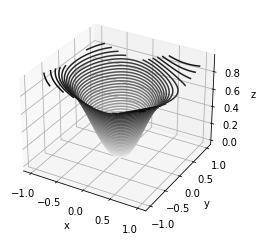

In [63]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 40, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Text(0.5, 0, 'Function Value')

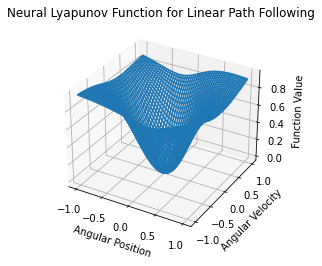

In [64]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z)
ax.set_title('Neural Lyapunov Function for Linear Path Following')
ax.set_xlabel('Angular Position')
ax.set_ylabel('Angular Velocity')
ax.set_zlabel('Function Value')

### Visulaization of Derivative

In [65]:
x1, x2 = sym.symbols('x1, x2')
v = sym.tanh((0.61537552178084731 - 1.6526986171373308 * sym.tanh((-1.3005985792784152 + 0.033455480448562551 * x1 - 0.029644806109788445 * x2)) + 1.1566275107713344 * sym.tanh((-0.99372641341776724 + 1.9573348407357949 * x1 + 0.60809805434635678 * x2)) + 1.2389179335917999 * sym.tanh((-0.92038043972211148 - 0.30485209627461601 * x1 - 1.3561506576737281 * x2)) + 1.3031971108425413 * sym.tanh((-0.87202433152478531 - 0.87134693378676686 * x1 + 1.0186313725728018 * x2)) - 0.56866226824325838 * sym.tanh((0.91114211735678641 + 0.88347226906685938 * x1 + 1.0211678851787513 * x2)) + 1.2024027114408209 * sym.tanh((1.2983763595181566 - 0.028069783153418543 * x1 + 0.031871644631621884 * x2))))

x1_deri = 6 * sym.sin(x2)
x2_deri = - x2 - 6 * sym.sin(x2) * x1 / x2 + (-0.847100019454956 * x1 -1.6413999795913696 * x2)

derivative = v.diff(x1) * x1_deri + v.diff(x2)* x2_deri
derivative =lambdify((x1, x2), derivative, "numpy")

In [66]:
x = np.linspace(-0.6, 0.6, 300)
y = np.linspace(-0.6, 0.6, 300)
X, Y = np.meshgrid(x, y)

Z = []
for i in range(300):
    temp = []
    for j in range(300):
        temp.append(derivative(x[i], x[j]))
    Z.append(temp)
Z = np.array(Z)
len(Z), len(Z[0])

(300, 300)

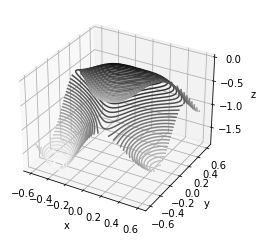

In [67]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 40, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Text(0.5, 0, 'Function Value')

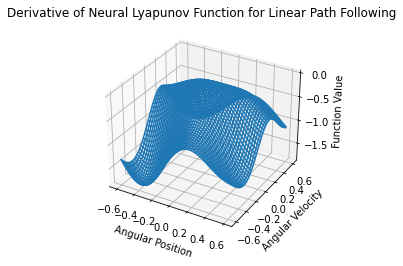

In [69]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z)
ax.set_title('Derivative of Neural Lyapunov Function for Linear Path Following')
ax.set_xlabel('Angular Position')
ax.set_ylabel('Angular Velocity')
ax.set_zlabel('Function Value')